### **O objetivo deste projeto é classificar dados emails do data set como spam(emails não solicitados/indesejados) ou ham (emails desejados)**

#### O Spam é parte do dia a dia de qualquer usuário da Internet. Esse tipo de mensagem, corresponde a 49,5% do total de 20 bilhões de e-mails enviados por dia no mundo todo. Aqui vamos receber uma base de dados e com ela treinar um modelo que poderá prever a classificação futuros emails entre spam ou ham. Utilizaremos a linguagem Python e faremos o uso de várias bibliotecas bastante úteis para um conjunto de dados que contem muitp texto.

#### O SMS Spam Collection v.1 é um conjunto público de mensagens rotuladas por SMS que foram coletadas para a pesquisa de spam em emails. Possui uma coleção composta por 5.574 mensagens em inglês, reais, marcadas como legítimas (ham) ou spam. O arquivo contendo os dados pode ser encontrado nesse link:
https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

### 1. **Carregamento dos dados**

In [50]:
#Analise dos dados
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


#vizualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

#avaliação do modelo 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
messages = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
messages['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
messages.isnull().sum()

label      0
message    0
dtype: int64

In [7]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

#### Percebemos que não há valores nulos no dataset. O problema que encontramos é que o dataset contem apenas duas colunas, uma delas contendo apenas strings, que são os textos dos emails. Para visualização dos dados, vamos criar uma coluna 'length' onde teremos a contagem de strings por email, assim será mais fácil tirar conclusões e agregará ao modelo.

In [8]:
messages['length'] = messages['message'].str.len()

In [9]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### **2. Visualização dos Dados**

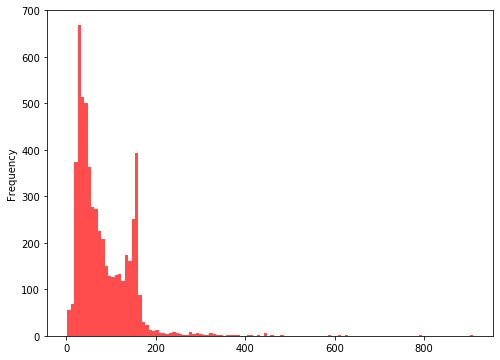

In [10]:
plt.figure(figsize=(8,6))
messages['length'].plot(kind='hist', bins=120, alpha=0.7, color='red')

#### Neste histograma percebemos que a maior parte das mensagens tem um tamanho de até 200 caracteres. Percebemos tambem alguns valores acima de 700, possivelmente mensagens contendo muito texto, portanto iremos localizá-las para ter certeza que irão agregar algo ao modelo

In [11]:
messages[messages['length'] >= 700]

,label,message,length
1085,ham,For me the love should start with attraction.i...,910
1863,ham,The last thing i ever wanted to do was hurt yo...,790


In [12]:
messages[messages['length'] >= 700]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [13]:
messages[messages['length'] >= 700]['message'].iloc[1]

"The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed."

#### **Percebemos que as mensagens são verídicas, classificadas como 'ham' e portanto importantes para o modelo.**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0631383490>,
      dtype=object)

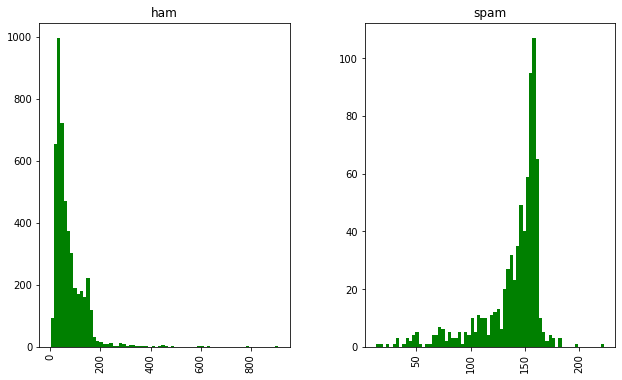

In [14]:
messages.hist(column='length', by='label', figsize=(10,6), bins=70, color='green')

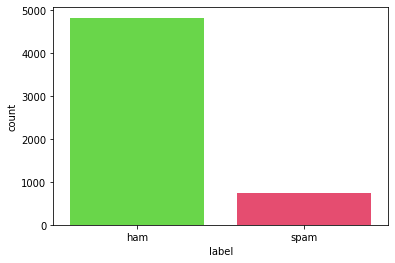

In [15]:
sns.countplot('label', data=messages, palette='prism', alpha=0.8)

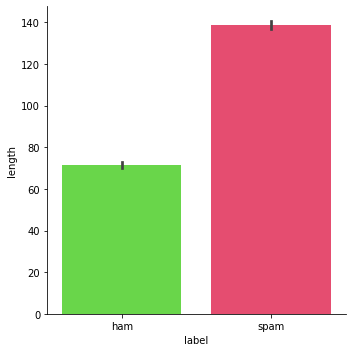

In [16]:
sns.catplot('label', 'length', data=messages, kind='bar', palette='prism', alpha=0.8)

#### Analisando os gráficos, observamos que existe uma quantidade maior de mensagens desejadas(ham), e mensagens spam são relativamente maiores, quando comparadas as mensagens ham

### 3. **Pré processamento do texto**

#### Precisamos modificar a coluna 'message', que está em valor de string. Os algoritmos de classificação que que serão utilizados precisam de algum tipo de vetor de características numéricas para realizar a tarefa de classificação. Usaremos a abordagem 'bag-of-words', onde cada palavra terá uma representação numérica. 

#### Para um pré tratamento dessa caracteristica, usaremos a biblioteca string do python, para retirar a pontuação dos emails e após isso, usaremos a biblioteca NLTK (Natural Language ToolKit) para remover as stopwords de cada linha do dataset

#### Será usado List Comprehension dentro de uma função para aplicar aos dados. Para melhor entendimento, aqui estão algumas palavras que são considerada 'stop words', e serão removidas pelo NLTK:

In [17]:
stopwords.words('english')[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [18]:
def text_process(text):
    #retirar pontuação
    no_punct = [char for char in text if char not in string.punctuation]
    #juntar strings
    no_punct = ''.join(no_punct)
    #retirar stopwords
    return [word for word in no_punct.split() if word.lower() not in stopwords.words('english')]

#### Testando a função

In [19]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

#### O próximo passo é realizar a vetorização das mensagens, transformando-as em um vetor que os modelos de aprendizagem de máquinas podem entender. Usaremos o CountVectorizer do ScyKit learn, que converterá uma coleção de documentos de texto em uma matriz de contagem de token(palavras que realmente queremos).

#### **Vamos fitar o objeto na coluna de mensagens, passando tambem a função que trata pontuação e stop words do texto**

In [20]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

#### Fazendo uma demonstração com uma mensagem do data set

In [21]:
test_message = messages['message'][4]
test_message

"Nah I don't think he goes to usf, he lives around here though"

In [22]:
bow_test = bow_transformer.transform([test_message])
print(bow_test)
print()
print(bow_test.shape)

  (0, 2948)	1
  (0, 4777)	1
  (0, 6123)	1
  (0, 6877)	1
  (0, 7842)	1
  (0, 10433)	1
  (0, 10450)	1
  (0, 10799)	1

(1, 11425)


#### **Agora temos um transformador funcional, só temos que aplicar ao resto das mensagens**

In [23]:
messages_bow = bow_transformer.transform(messages['message'])

#### **Temos agora uma matriz esparsa do DataFrame, que o modelo conseguirá interpretar e aprender.**

In [24]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


#### Iremos agora utilizar o TF-IDF Transformer, do ScyKit learn, para calcular o peso de cada palavra no texto.

In [25]:
messages_transformer = TfidfTransformer().fit(messages_bow)

In [26]:
tfidf_test = messages_transformer.transform(bow_test)
print(tfidf_test)

  (0, 10799)	0.4019015462543087
  (0, 10450)	0.35407004444444734
  (0, 10433)	0.27043580251222216
  (0, 7842)	0.4457437273623316
  (0, 6877)	0.35407004444444734
  (0, 6123)	0.24090226292109554
  (0, 4777)	0.3104226271508041
  (0, 2948)	0.4019015462543087


In [27]:
messages_tfidf = messages_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


### **4. Treinando um modelo**

In [28]:
X = messages_tfidf
y = messages['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### **Podemos agora usar uma Pipeline para definir todas as funções anteriores e nossas funções de treinamento. Para este Data Set, treinaremos um modelo NaiveBayes e uma RandomForest, fazendo os devidos testes para analisar qual realiza as melhores predições**

#### **Multinomial NB**

In [29]:
bayes = MultinomialNB()

In [30]:
bayes.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
pred_bayes = bayes.predict(X_test)

In [37]:
y_train

5353     ham
3772     ham
3371     ham
2072     ham
4054     ham
        ... 
2219     ham
357     spam
837     spam
4543    spam
4353     ham
Name: label, Length: 3900, dtype: object

#### **Random Forest**

In [39]:
message_train, message_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.3)

In [51]:
forest = RandomForestClassifier(n_estimators=400)

pipeline_rfc = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tf-idf', TfidfTransformer()),
    ('classifier', AdaBoostClassifier(base_estimator=forest, learning_rate=0.01))
])

In [52]:
pipeline_rfc.fit(message_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f06310254d0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b...
                                                                          max_depth=None,
                                                                          max_features='auto',
                                                                          max_leaf_nodes=None,
                                                                          max_samples=No

In [53]:
pred_rfc = pipeline_rfc.predict(message_test)

### **5. Avaliação do Modelo**

In [54]:
#score Bayes
print('Modelo Bayes: ')
print(classification_report(pred_bayes, y_test))
print('Accuracy: ', accuracy_score(pred_bayes, y_test))

Modelo Bayes: 
              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1512
        spam       0.72      1.00      0.84       160

    accuracy                           0.96      1672
   macro avg       0.86      0.98      0.91      1672
weighted avg       0.97      0.96      0.97      1672

Accuracy:  0.9629186602870813


In [55]:
#score Random Forest
print(classification_report(pred_rfc, label_test))
print()
print('Accuracy: ', accuracy_score(pred_rfc, label_test))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99      1487
        spam       0.84      0.99      0.91       185

    accuracy                           0.98      1672
   macro avg       0.92      0.98      0.95      1672
weighted avg       0.98      0.98      0.98      1672


Accuracy:  0.9778708133971292


#### **Percebemos um modelo um pouco melhor utitlizando RandomForest, com uma chance de acerto de 98%**